In [12]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pandas as pd
from matplotlib.ticker import FormatStrFormatter


import HERA_hack_FG
import pspec
import make_universe

# import sys
# sys.path.insert(0, '/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Pipeline')
# import Interferometer_sim

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [406]:
######### TELESCOPE AND OBS ########


dishes = np.array([[0,0],[0,55],[30,30],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])
data = np.loadtxt('/Users/hannahfronenberg/desktop/MSC1/HERA Noise/hera_positions_staged/antenna_positions_128.dat')
hera_bls = data[:,:-1]

hera_bls_long = []

for i in range(hera_bls.shape[0]):
    mag = np.sqrt(hera_bls[i,0]**2+hera_bls[i,1]**2)
    if mag >= 50:
        hera_bls_long.append(hera_bls[i])
    else:
        continue
        
hera_bls_long = np.asarray(hera_bls_long)[::3]
print(hera_bls_long.shape)

#observable corners of the sky [lat,long]
acorner = np.array([[120,270],[122,280],[120,280],[122,270]]) ## Why have the first to sky corners?? 

HERA = HERA_hack_FG.telescope(hera_bls, latitude=-30, channel_width=0.1, Tsys=300, beam_width=3, beam = 'gaussian')

obs5 = HERA_hack_FG.observation(HERA, 100, 150, 0.01,acorner,1, 0.31, norm = False, pbeam = True)
obs0 = HERA_hack_FG.observation(HERA, 1, 150, 0.01,acorner,1, 0.2, norm = False, pbeam = False)
obs = HERA_hack_FG.observation(HERA, 100, 150, 0.01,acorner,1, 0.2, norm = False, pbeam = True)

## as per sauarbh's prescription, I decreased the wavelengths  


(30, 2)


In [381]:
print(obs.sky_shape())
print(obs.Npix)

(30, 50)
1500


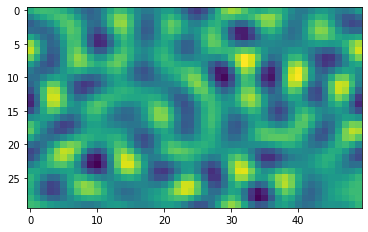

In [403]:
###### DEFINE THEORY PSPEC #######

def ps(x):
    mu, sigma = 0.07,0.007
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

######## MAKE THE UNIVERSE #######

make_uni = make_universe.universe(ps,row_npix = obs.sky_shape()[0], col_npix = obs.sky_shape()[1],  Ly = 70,Lx = 100, mean = )#100 Mpc by 100Mpc
universe = make_uni.make_2D_universe()
universe_T = universe.T 
stacked_sky = np.hstack(universe.T)

plt.imshow(universe)

In [407]:
sky = np.real(obs.convolve_map(stacked_sky,None,None))

Text(0.5, 1, 'Universe')

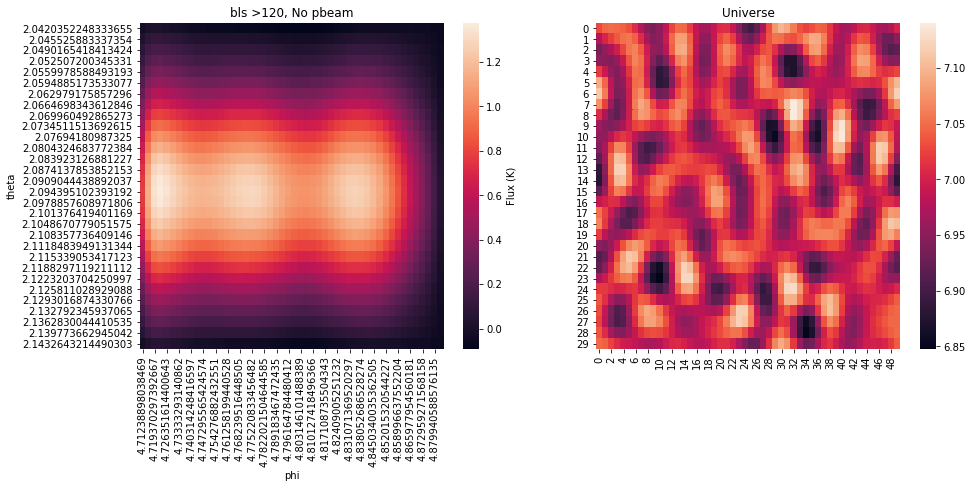

In [408]:
npix = len(obs.observable_coordinates())

#making separate arrays of theta and phi for data vis
x = obs.observable_coordinates()[:,1] #phi
y = obs.observable_coordinates()[:,0]#theta

df = pd.DataFrame.from_dict(np.array([x,y,sky]).T)
df.columns = ['phi','theta','temp']
pivotted_obs= df.pivot('theta','phi','temp')

fig, ax = plt.subplots(1,2, figsize = (15,6))
sns.heatmap(pivotted_obs,ax=ax[0],cbar_kws={'label': 'Flux (K)'})
ax[0].set_title('bls >120, No pbeam', y = 1.04)
sns.heatmap(universe, ax = ax[1],)
ax[1].set_title('Universe')


MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


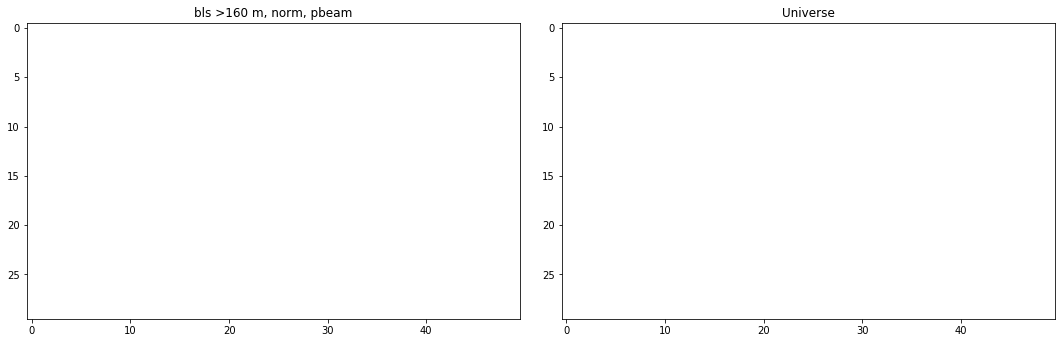

In [362]:
from celluloid import Camera

fig, ax = plt.subplots(1,2, figsize = (15,6))
fig.tight_layout()#if I want title to change I need to put the ax inside the loop.
camera = Camera(fig)

# set up random seed

universe = make_uni.make_2D_universe()
universe_T = universe.T 

#running diff baseline lengths

min_bls = [70,80,90,100,110,120,130,140,150,160]
h = 0
for i in range(len(min_bls)):
    
    hera_bls_long = []

    for i in range(hera_bls.shape[0]):
        mag = np.sqrt(hera_bls[i,0]**2+hera_bls[i,1]**2)
        if mag >= min_bls[h]:
            hera_bls_long.append(hera_bls[i])
        else:
            continue
    if min_bls[h] >=120:
        hera_bls_long = np.asarray(hera_bls_long)
    else: 
         hera_bls_long = np.asarray(hera_bls_long)[::2]
    
    HERA = HERA_hack_FG.telescope(hera_bls_long, latitude=-30, channel_width=0.1, Tsys=300, beam_width=3, beam = 'gaussian')

    obs5 = HERA_hack_FG.observation(HERA, 100, 1500, 0.01,acorner,1, 0.2, norm = False, pbeam = False)
    sky = np.real(obs5.convolve_map(stacked_sky,None,None))
    
    x = obs5.observable_coordinates()[:,1] #phi
    y = obs5.observable_coordinates()[:,0]#theta

    df = pd.DataFrame.from_dict(np.array([x,y,sky]).T)
    df.columns = ['phi','theta','temp']
    pivotted_obs= df.pivot('theta','phi','temp')
    
    j = min_bls[h]

    ax[0].imshow(pivotted_obs)
    ax[0].set_title('bls >%s m, norm, pbeam'%j, y = 1.04)
    ax[1].imshow(universe)
    ax[1].set_title('Universe')


    h+=1
    camera.snap()

animation = camera.animate()

from IPython.display import HTML
HTML(animation.to_jshtml())

animation.save('mean_ani_1500_1.gif')

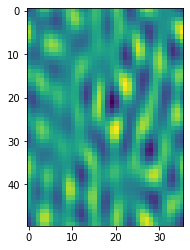

In [312]:
freq_bins = np.arange(185,310,0.4)

In [313]:
len(freq_bins)

313

In [314]:
freq_bins

array([185. , 185.4, 185.8, 186.2, 186.6, 187. , 187.4, 187.8, 188.2,
       188.6, 189. , 189.4, 189.8, 190.2, 190.6, 191. , 191.4, 191.8,
       192.2, 192.6, 193. , 193.4, 193.8, 194.2, 194.6, 195. , 195.4,
       195.8, 196.2, 196.6, 197. , 197.4, 197.8, 198.2, 198.6, 199. ,
       199.4, 199.8, 200.2, 200.6, 201. , 201.4, 201.8, 202.2, 202.6,
       203. , 203.4, 203.8, 204.2, 204.6, 205. , 205.4, 205.8, 206.2,
       206.6, 207. , 207.4, 207.8, 208.2, 208.6, 209. , 209.4, 209.8,
       210.2, 210.6, 211. , 211.4, 211.8, 212.2, 212.6, 213. , 213.4,
       213.8, 214.2, 214.6, 215. , 215.4, 215.8, 216.2, 216.6, 217. ,
       217.4, 217.8, 218.2, 218.6, 219. , 219.4, 219.8, 220.2, 220.6,
       221. , 221.4, 221.8, 222.2, 222.6, 223. , 223.4, 223.8, 224.2,
       224.6, 225. , 225.4, 225.8, 226.2, 226.6, 227. , 227.4, 227.8,
       228.2, 228.6, 229. , 229.4, 229.8, 230.2, 230.6, 231. , 231.4,
       231.8, 232.2, 232.6, 233. , 233.4, 233.8, 234.2, 234.6, 235. ,
       235.4, 235.8,